# HuBMAP - Exploratory Data Analysis

Quick Exploratory Data Analysis for [HuBMAP: Hacking the Kidney](https://www.kaggle.com/c/hubmap-kidney-segmentation) challenge

The HuBMAP data used in this hackathon includes 11 fresh frozen and 9 Formalin Fixed Paraffin Embedded (FFPE) PAS kidney images. Glomeruli FTU annotations exist for all 20 tissue samples; some of these will be shared for training, and others will be used to judge submissions.

![](https://storage.googleapis.com/kaggle-competitions/kaggle/22990/logos/header.png)

<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:#EAA6D1; border:0' role="tab" aria-controls="home"><center>Quick Navigation</center></h3>

* [1. Basic Data Exploration](#1)
* [2. Image and Masks Visualizations](#2)
* [3. Metadata Analysis](#3)

In [1]:
# !pip install -q -U pip
# !pip install -q -U seaborn

<a id="1"></a>
<h2 style='background:#EAA6D1; border:0; color:white'><center>Basic Data Exploration<center><h2>

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import cv2
import tifffile

In [3]:
# BASE_PATH = "../input/hubmap-kidney-segmentation/"
BASE_PATH = "../data/"
TRAIN_PATH = os.path.join(BASE_PATH, "train")

print(os.listdir(BASE_PATH))

['wsi_meta.csv', 'test', 'tile_meta.csv', 'sample_submission.csv', 'train', 'hubmap-hacking-the-human-vasculature.zip', 'polygons.jsonl']


### Train masks

**train.csv** contains the unique IDs for each image, as well as an RLE-encoded representation of the mask for the objects in the image. See the evaluation tab for details of the RLE encoding scheme.

In [4]:
df_train = pd.read_csv(
    os.path.join(BASE_PATH, "train.csv")
)
df_train

FileNotFoundError: [Errno 2] No such file or directory: '../data/train.csv'

### Submission df

In [5]:
df_sub = pd.read_csv(
    os.path.join(BASE_PATH, "sample_submission.csv"))
df_sub

id  predicted
0  2ec3f1bb9        NaN
1  3589adb90        NaN
2  d488c759a        NaN
3  aa05346ff        NaN
4  57512b7f1        NaN

### Number of samples

In [6]:
print(f"Number of train images: {df_train.shape[0]}")
print(f"Number of test images: {df_sub.shape[0]}")

Number of train images: 15
Number of test images: 5


### Train and test metadata

**HuBMAP-20-dataset_information.csv** contains additional information (including anonymized patient data) about each image.

In [7]:
df_info = pd.read_csv(
    os.path.join(BASE_PATH, "HuBMAP-20-dataset_information.csv")
)
df_info.sample(3)

image_file  width_pixels  height_pixels  \
19  8242609fa.tiff         44066          31299   
14  b2dc8411c.tiff         31262          14844   
0   aa05346ff.tiff         47340          30720   

   anatomical_structures_segmention_file glomerulus_segmentation_file  \
19   8242609fa-anatomical-structure.json               8242609fa.json   
14   b2dc8411c-anatomical-structure.json               b2dc8411c.json   
0    aa05346ff-anatomical-structure.json               aa05346ff.json   

    patient_number                       race               ethnicity     sex  \
19           66999                      White  Not Hispanic or Latino    Male   
14           67026  Black or African American  Not Hispanic or Latino    Male   
0            67347                      White  Not Hispanic or Latino  Female   

    age  weight_kilograms  height_centimeters  bmi_kg/m^2 laterality  \
19   56              91.4               181.6        27.7      Right   
14   53              73.0               166.0        26.5       Left   
0    58              59.0               160.0        23.0      Right   

    percent_cortex  percent_medulla  
19              65               35  
14              55               45  
0               80               20

## Utility functions

In [8]:
# https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape).T


def read_image(image_id, scale=None, verbose=1):
    image = tifffile.imread(
        os.path.join(BASE_PATH, f"train/{image_id}.tiff")
    )
    print(image.shape)
    if len(image.shape) == 5 or image.shape[0] == 3:
        image = image.squeeze().transpose(1, 2, 0)
    
    mask = rle2mask(
        df_train[df_train["id"] == image_id]["encoding"].values[0], 
        (image.shape[1], image.shape[0])
    )
    
    if verbose:
        print(f"[{image_id}] Image shape: {image.shape}")
        print(f"[{image_id}] Mask shape: {mask.shape}")
    
    if scale:
        new_size = (image.shape[1] // scale, image.shape[0] // scale)
        image = cv2.resize(image, new_size)
        mask = cv2.resize(mask, new_size)
        
        if verbose:
            print(f"[{image_id}] Resized Image shape: {image.shape}")
            print(f"[{image_id}] Resized Mask shape: {mask.shape}")
        
    return image, mask


def read_test_image(image_id, scale=None, verbose=1):
    image = tifffile.imread(
        os.path.join(BASE_PATH, f"test/{image_id}.tiff")
    )
    if len(image.shape) == 5 or image.shape[0] == 3:
        image = image.squeeze().transpose(1, 2, 0)
    
    if verbose:
        print(f"[{image_id}] Image shape: {image.shape}")
    
    if scale:
        new_size = (image.shape[1] // scale, image.shape[0] // scale)
        image = cv2.resize(image, new_size)
        
        if verbose:
            print(f"[{image_id}] Resized Image shape: {image.shape}")
        
    return image


def plot_image_and_mask(image, mask, image_id):
    plt.figure(figsize=(16, 10))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f"Image {image_id}", fontsize=18)
    
    plt.subplot(1, 3, 2)
    plt.imshow(image)
    plt.imshow(mask, cmap="hot", alpha=0.5)
    plt.title(f"Image {image_id} + mask", fontsize=18)    
    
    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap="hot")
    plt.title(f"Mask", fontsize=18)    
    
    plt.show()
    
    
def plot_grid_image_with_mask(image, mask):
    plt.figure(figsize=(16, 16))
    
    w_len = image.shape[0]
    h_len = image.shape[1]
    
    min_len = min(w_len, h_len)
    w_start = (w_len - min_len) // 2
    h_start = (h_len - min_len) // 2
    
    plt.imshow(image[w_start : w_start + min_len, h_start : h_start + min_len])
    plt.imshow(
        mask[w_start : w_start + min_len, h_start : h_start + min_len], cmap="hot", alpha=0.5,
    )
    plt.axis("off")
            
    plt.show()
    

def plot_slice_image_and_mask(image, mask, start_h, end_h, start_w, end_w):
    plt.figure(figsize=(16, 5))
    
    sub_image = image[start_h:end_h, start_w:end_w, :]
    sub_mask = mask[start_h:end_h, start_w:end_w]
    
    plt.subplot(1, 3, 1)
    plt.imshow(sub_image)
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(sub_image)
    plt.imshow(sub_mask, cmap="hot", alpha=0.5)
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(sub_mask, cmap="hot")
    plt.axis("off")
    
    plt.show()

<a id="2"></a>
<h2 style='background:#EAA6D1; border:0; color:white'><center>Image and Masks Visualizations<center><h2>

In [9]:
small_ids = [
    "0486052bb", "095bf7a1f", "1e2425f28", "2f6ecfcdf",
    "54f2eec69", "aaa6a05cc", "cb2d976f4", "e79de561c",
]
small_images = []
small_masks = []

for small_id in small_ids:
    tmp_image, tmp_mask = read_image(small_id, scale=20, verbose=1)
    small_images.append(tmp_image)
    small_masks.append(tmp_mask)

(25784, 34937, 3)
[0486052bb] Image shape: (25784, 34937, 3)
[0486052bb] Mask shape: (25784, 34937)
[0486052bb] Resized Image shape: (1289, 1746, 3)
[0486052bb] Resized Mask shape: (1289, 1746)
(3, 38160, 39000)
[095bf7a1f] Image shape: (38160, 39000, 3)
[095bf7a1f] Mask shape: (38160, 39000)
[095bf7a1f] Resized Image shape: (1908, 1950, 3)
[095bf7a1f] Resized Mask shape: (1908, 1950)
(3, 26780, 32220)
[1e2425f28] Image shape: (26780, 32220, 3)
[1e2425f28] Mask shape: (26780, 32220)
[1e2425f28] Resized Image shape: (1339, 1611, 3)
[1e2425f28] Resized Mask shape: (1339, 1611)
(31278, 25794, 3)
[2f6ecfcdf] Image shape: (31278, 25794, 3)
[2f6ecfcdf] Mask shape: (31278, 25794)
[2f6ecfcdf] Resized Image shape: (1563, 1289, 3)
[2f6ecfcdf] Resized Mask shape: (1563, 1289)
(1, 1, 3, 30440, 22240)
[54f2eec69] Image shape: (30440, 22240, 3)
[54f2eec69] Mask shape: (30440, 22240)
[54f2eec69] Resized Image shape: (1522, 1112, 3)
[54f2eec69] Resized Mask shape: (1522, 1112)
(18484, 13013, 3)
[aaa6a

## Train images

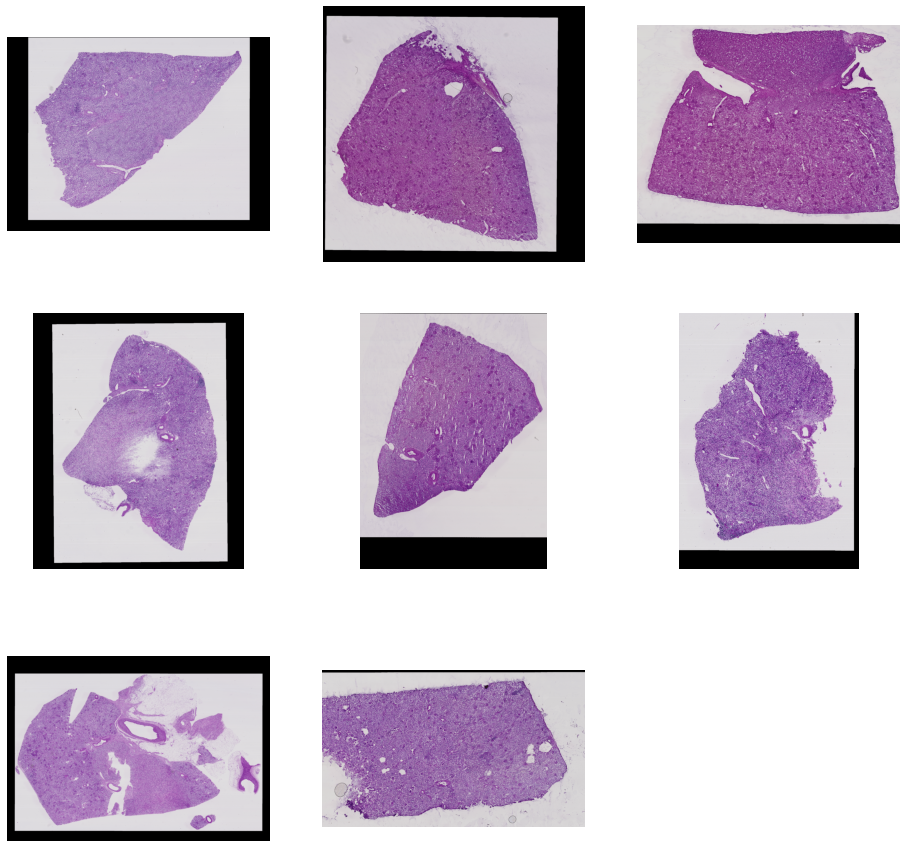

In [10]:
plt.figure(figsize=(16, 16))
for ind, (tmp_id, tmp_image) in enumerate(zip(small_ids, small_images)):
    plt.subplot(3, 3, ind + 1)
    plt.imshow(tmp_image)
    plt.axis("off")

## Train images + masks

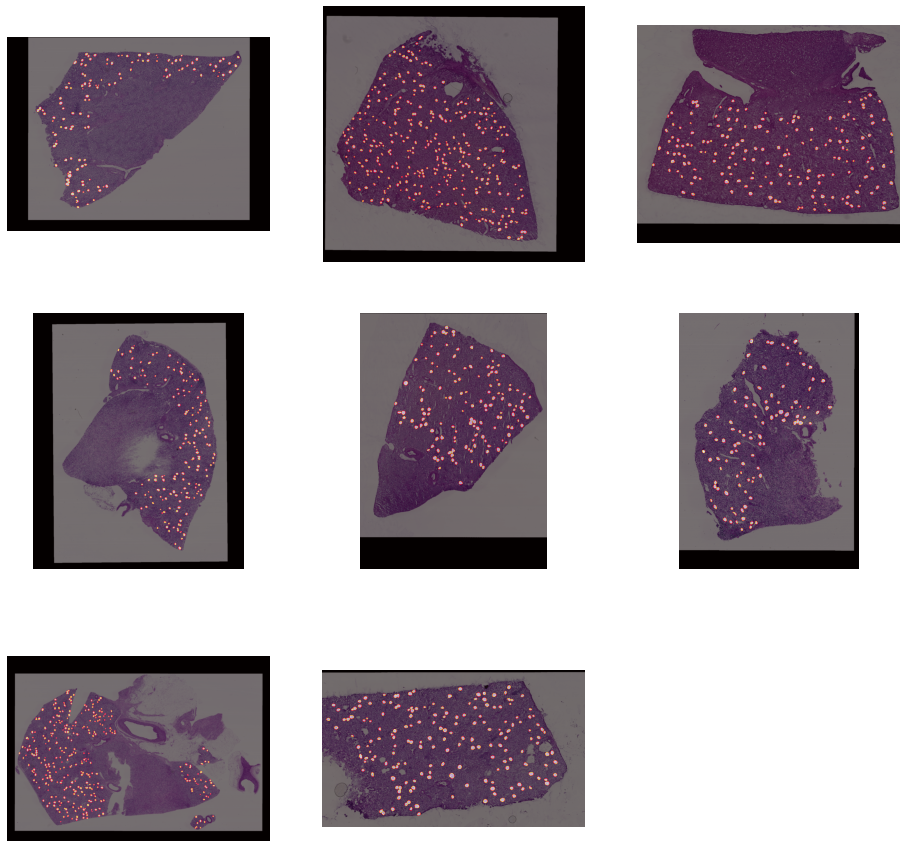

In [11]:
plt.figure(figsize=(16, 16))
for ind, (tmp_id, tmp_image, tmp_mask) in enumerate(zip(small_ids, small_images, small_masks)):
    plt.subplot(3, 3, ind + 1)
    plt.imshow(tmp_image)
    plt.imshow(tmp_mask, cmap="hot", alpha=0.5)
    plt.axis("off")

In [12]:
small_ids = [
    "2ec3f1bb9", "3589adb90", "57512b7f1", "aa05346ff", "d488c759a",
]
small_images = []

for small_id in small_ids:
    tmp_image = read_test_image(small_id, scale=20, verbose=1)
    small_images.append(tmp_image)

[2ec3f1bb9] Image shape: (23990, 47723, 3)
[2ec3f1bb9] Resized Image shape: (1199, 2386, 3)
[3589adb90] Image shape: (29433, 22165, 3)
[3589adb90] Resized Image shape: (1471, 1108, 3)
[57512b7f1] Image shape: (33240, 43160, 3)
[57512b7f1] Resized Image shape: (1662, 2158, 3)
[aa05346ff] Image shape: (30720, 47340, 3)
[aa05346ff] Resized Image shape: (1536, 2367, 3)
[d488c759a] Image shape: (46660, 29020, 3)
[d488c759a] Resized Image shape: (2333, 1451, 3)


## Test images

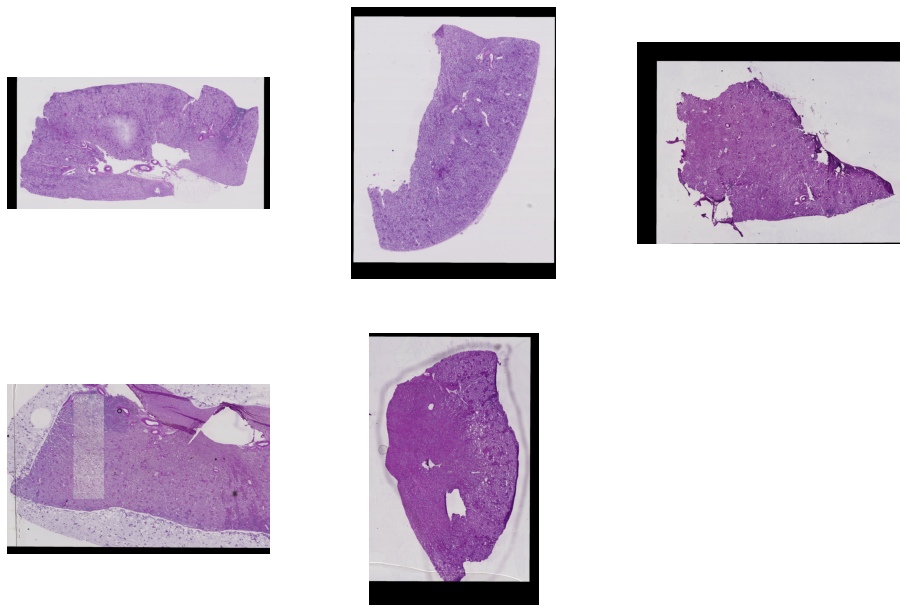

In [13]:
plt.figure(figsize=(16, 11))
for ind, (tmp_id, tmp_image) in enumerate(zip(small_ids, small_images)):
    plt.subplot(2, 3, ind + 1)
    plt.imshow(tmp_image)
    plt.axis("off")

## 0486052bb

In [14]:
image_id = "0486052bb"
image, mask = read_image(image_id, 2)

(25784, 34937, 3)
[0486052bb] Image shape: (25784, 34937, 3)
[0486052bb] Mask shape: (25784, 34937)
[0486052bb] Resized Image shape: (12892, 17468, 3)
[0486052bb] Resized Mask shape: (12892, 17468)


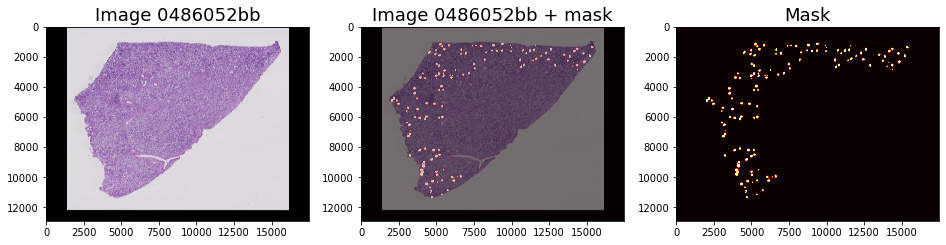

In [15]:
plot_image_and_mask(image, mask, image_id)

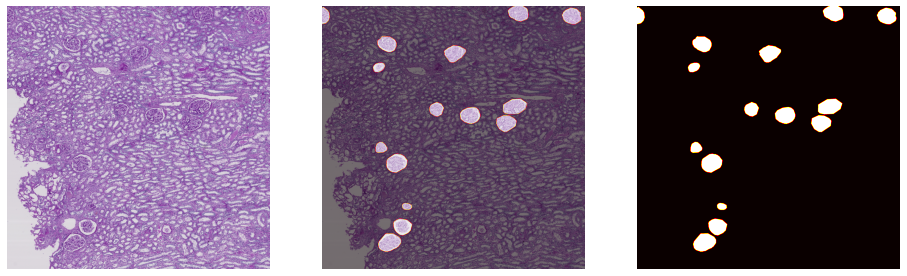

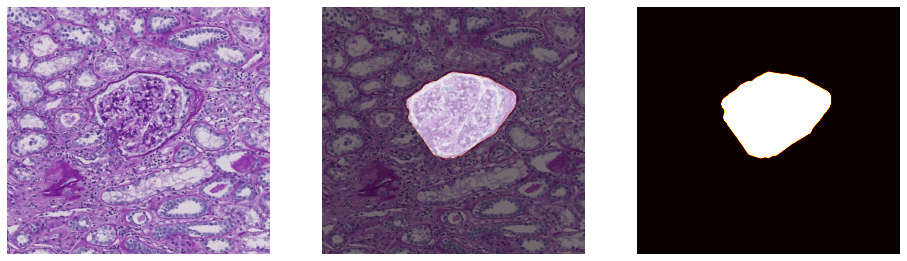

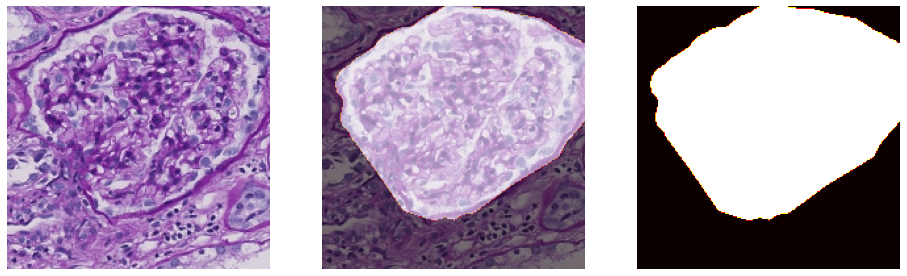

In [16]:
plot_slice_image_and_mask(image, mask, 5000, 7500, 2500, 5000)
plot_slice_image_and_mask(image, mask, 5250, 5720, 3500, 4000)
plot_slice_image_and_mask(image, mask, 5375, 5575, 3650, 3850)

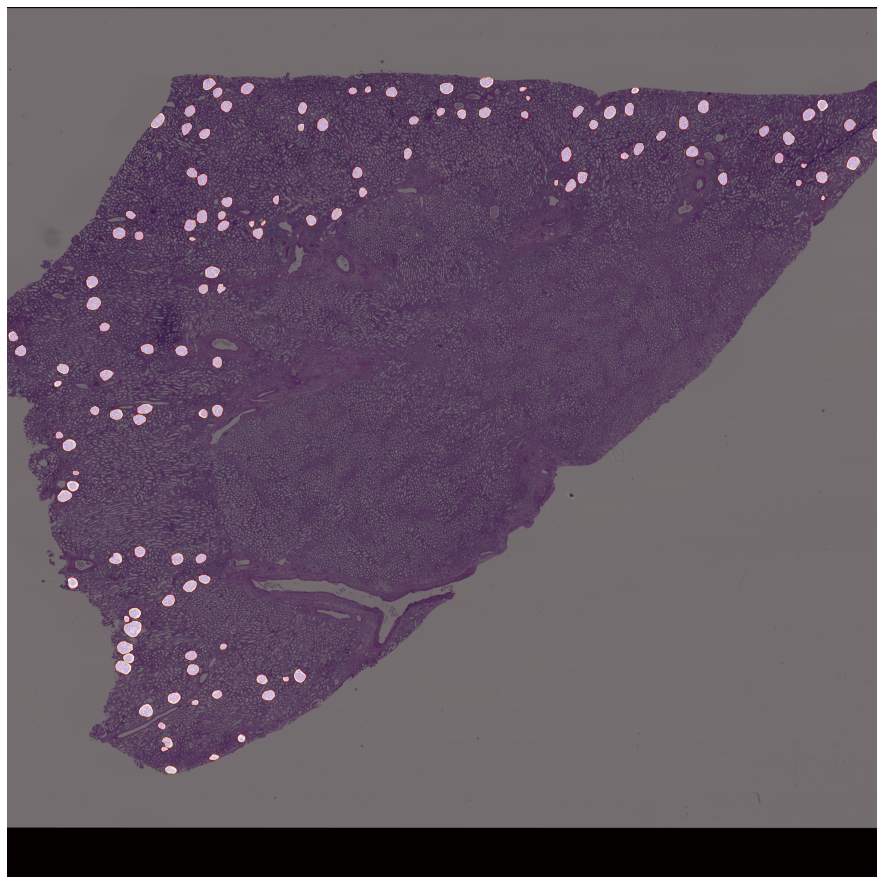

In [17]:
plot_grid_image_with_mask(image, mask)

## 095bf7a1f

In [18]:
image_id = "095bf7a1f"
image, mask = read_image(image_id, scale=2)

(3, 38160, 39000)
[095bf7a1f] Image shape: (38160, 39000, 3)
[095bf7a1f] Mask shape: (38160, 39000)
[095bf7a1f] Resized Image shape: (19080, 19500, 3)
[095bf7a1f] Resized Mask shape: (19080, 19500)


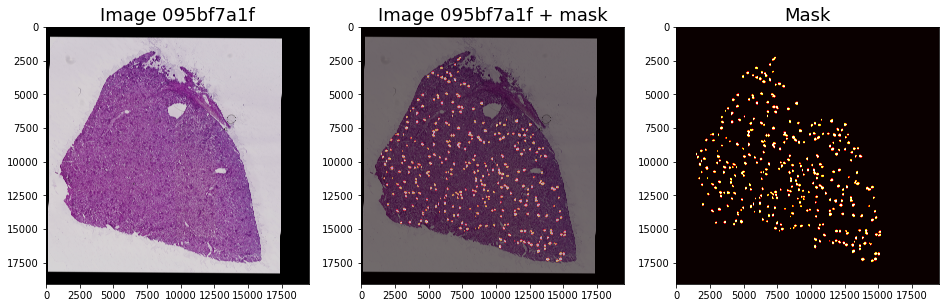

In [19]:
plot_image_and_mask(image, mask, image_id)

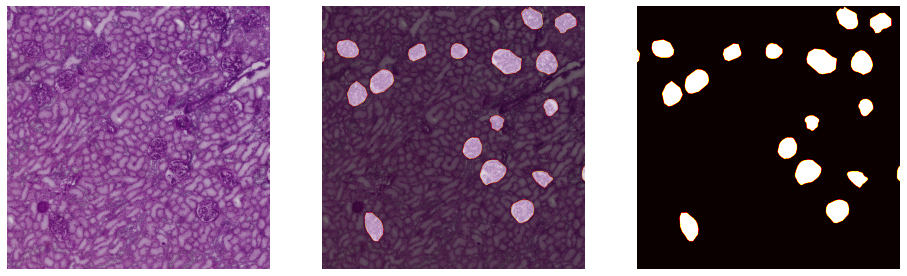

In [20]:
plot_slice_image_and_mask(image, mask, 7500, 10000, 10000, 12500)

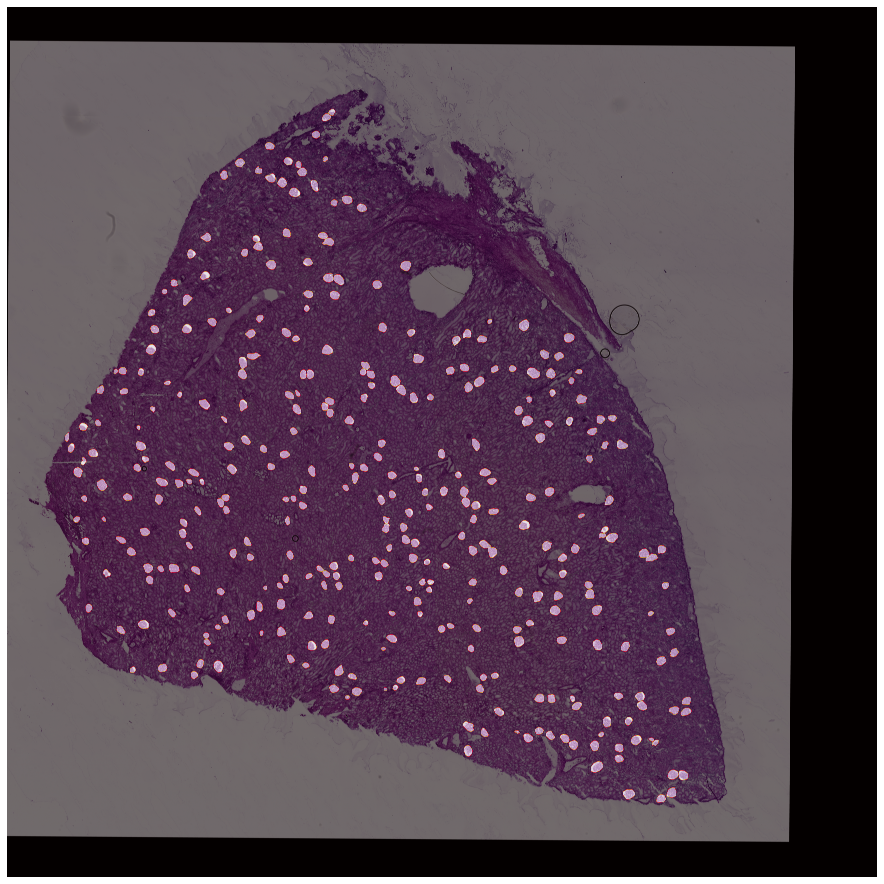

In [21]:
plot_grid_image_with_mask(image, mask)

## 1e2425f28

In [22]:
image_id = "1e2425f28"
image, mask = read_image(image_id, scale=2)

(3, 26780, 32220)
[1e2425f28] Image shape: (26780, 32220, 3)
[1e2425f28] Mask shape: (26780, 32220)
[1e2425f28] Resized Image shape: (13390, 16110, 3)
[1e2425f28] Resized Mask shape: (13390, 16110)


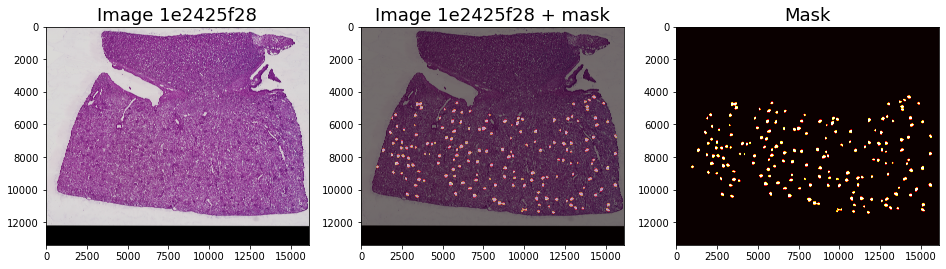

In [23]:
plot_image_and_mask(image, mask, image_id)

## 2f6ecfcdf

In [24]:
image_id = "2f6ecfcdf"
image, mask = read_image(image_id, scale=2)

(31278, 25794, 3)
[2f6ecfcdf] Image shape: (31278, 25794, 3)
[2f6ecfcdf] Mask shape: (31278, 25794)
[2f6ecfcdf] Resized Image shape: (15639, 12897, 3)
[2f6ecfcdf] Resized Mask shape: (15639, 12897)


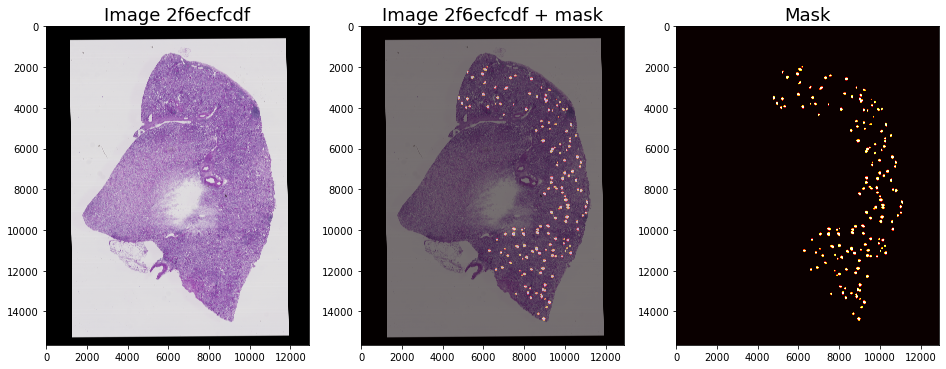

In [25]:
plot_image_and_mask(image, mask, image_id)

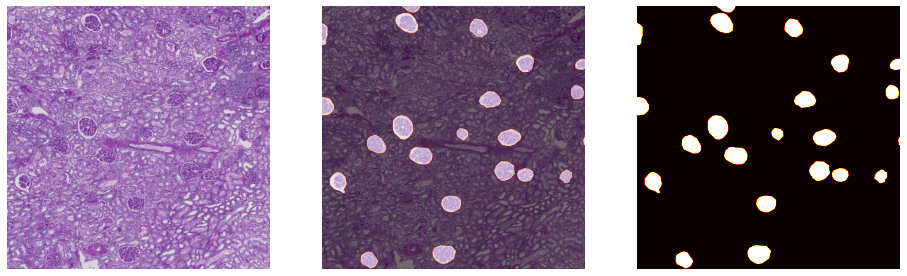

In [26]:
plot_slice_image_and_mask(image, mask, 10000, 12000, 8000, 10000)

## aaa6a05cc

In [27]:
image_id = "aaa6a05cc"
image, mask = read_image(image_id)

(18484, 13013, 3)
[aaa6a05cc] Image shape: (18484, 13013, 3)
[aaa6a05cc] Mask shape: (18484, 13013)


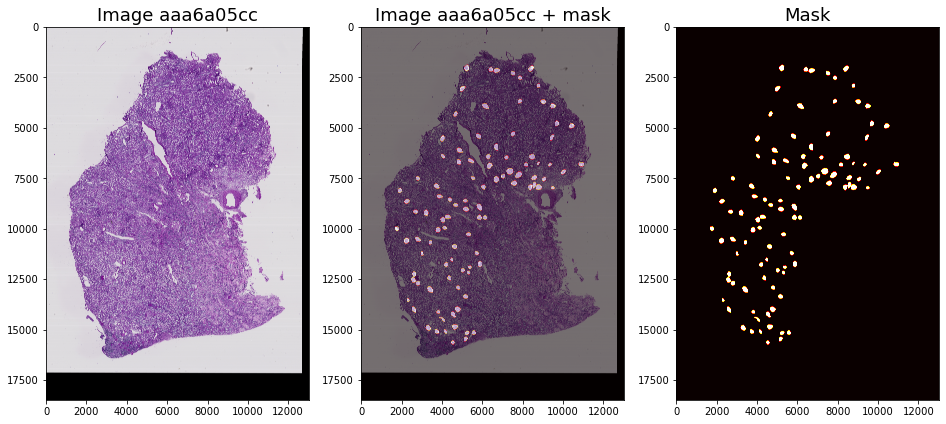

In [28]:
plot_image_and_mask(image, mask, image_id)

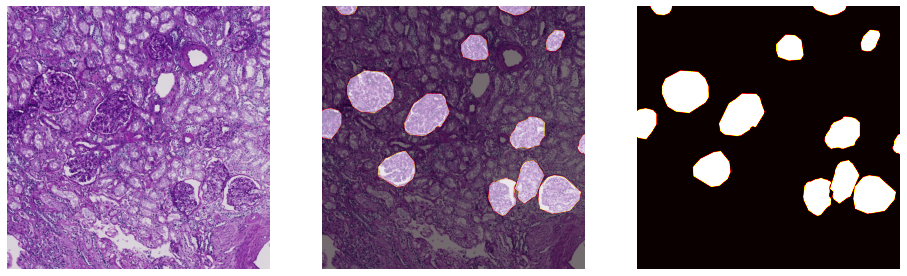

In [29]:
plot_slice_image_and_mask(image, mask, 6500, 8500, 7000, 9000)

## e79de561c

In [30]:
# image_id = "e79de561c"
# image, mask = read_image(image_id)

In [31]:
# plot_image_and_mask(image, mask, image_id)

In [32]:
# plot_slice_image_and_mask(image, mask, 4000, 6000, 2000, 4000)

<a id="3"></a>
<h2 style='background:#EAA6D1; border:0; color:white'><center>Metadata Analysis<center><h2>

In [33]:
pd.read_json(
    os.path.join(BASE_PATH, "train/0486052bb-anatomical-structure.json")
)

type                    id  \
0  Feature  PathAnnotationObject   
1  Feature  PathAnnotationObject   

                                            geometry  \
0  {'type': 'Polygon', 'coordinates': [[[20606, 4...   
1  {'type': 'Polygon', 'coordinates': [[[30717, 1...   

                                          properties  
0  {'classification': {'name': 'Medulla', 'colorR...  
1  {'classification': {'name': 'Cortex', 'colorRG...

In [34]:
pd.read_json(
    os.path.join(BASE_PATH, "train/0486052bb.json")
)

type                    id  \
0    Feature  PathAnnotationObject   
1    Feature  PathAnnotationObject   
2    Feature  PathAnnotationObject   
3    Feature  PathAnnotationObject   
4    Feature  PathAnnotationObject   
..       ...                   ...   
125  Feature  PathAnnotationObject   
126  Feature  PathAnnotationObject   
127  Feature  PathAnnotationObject   
128  Feature  PathAnnotationObject   
129  Feature  PathAnnotationObject   

                                              geometry  \
0    {'type': 'Polygon', 'coordinates': [[[7498, 10...   
1    {'type': 'Polygon', 'coordinates': [[[11693, 2...   
2    {'type': 'Polygon', 'coordinates': [[[25205, 2...   
3    {'type': 'Polygon', 'coordinates': [[[13342, 2...   
4    {'type': 'Polygon', 'coordinates': [[[6089, 11...   
..                                                 ...   
125  {'type': 'Polygon', 'coordinates': [[[28689, 2...   
126  {'type': 'Polygon', 'coordinates': [[[29653, 4...   
127  {'type': 'Polygon', 'coordinates': [[[7487, 93...   
128  {'type': 'Polygon', 'coordinates': [[[10826, 2...   
129  {'type': 'Polygon', 'coordinates': [[[18870, 2...   

                                            properties  
0    {'classification': {'name': 'glomerulus', 'col...  
1    {'classification': {'name': 'glomerulus', 'col...  
2    {'classification': {'name': 'glomerulus', 'col...  
3    {'classification': {'name': 'glomerulus', 'col...  
4    {'classification': {'name': 'glomerulus', 'col...  
..                                                 ...  
125  {'classification': {'name': 'glomerulus', 'col...  
126  {'classification': {'name': 'glomerulus', 'col...  
127  {'classification': {'name': 'glomerulus', 'col...  
128  {'classification': {'name': 'glomerulus', 'col...  
129  {'classification': {'name': 'glomerulus', 'col...  

[130 rows x 4 columns]

In [35]:
df_info["split"] = "test"
df_info.loc[df_info["image_file"].isin(os.listdir(os.path.join(BASE_PATH, "train"))), "split"] = "train"

In [36]:
df_info["area"] = df_info["width_pixels"] * df_info["height_pixels"]

In [37]:
df_info.head()

image_file  width_pixels  height_pixels  \
0  aa05346ff.tiff         47340          30720   
1  afa5e8098.tiff         43780          36800   
2  54f2eec69.tiff         22240          30440   
3  d488c759a.tiff         29020          46660   
4  1e2425f28.tiff         32220          26780   

  anatomical_structures_segmention_file glomerulus_segmentation_file  \
0   aa05346ff-anatomical-structure.json               aa05346ff.json   
1   afa5e8098-anatomical-structure.json               afa5e8098.json   
2   54f2eec69-anatomical-structure.json               54f2eec69.json   
3   d488c759a-anatomical-structure.json               d488c759a.json   
4   1e2425f28-anatomical-structure.json               1e2425f28.json   

   patient_number                       race               ethnicity     sex  \
0           67347                      White  Not Hispanic or Latino  Female   
1           67347                      White  Not Hispanic or Latino  Female   
2           67548  Black or African American  Not Hispanic or Latino    Male   
3           68138                      White  Not Hispanic or Latino  Female   
4           63921                      White  Not Hispanic or Latino    Male   

   age  weight_kilograms  height_centimeters  bmi_kg/m^2 laterality  \
0   58              59.0               160.0        23.0      Right   
1   58              59.0               160.0        23.0      Right   
2   58              79.9               190.5        22.0      Right   
3   66              81.5               158.8        32.2       Left   
4   48             131.5               193.0        35.3      Right   

   percent_cortex  percent_medulla  split        area  
0              80               20   test  1454284800  
1              55               45  train  1611104000  
2              75               25  train   676985600  
3             100                0   test  1354073200  
4              65               35  train   862851600

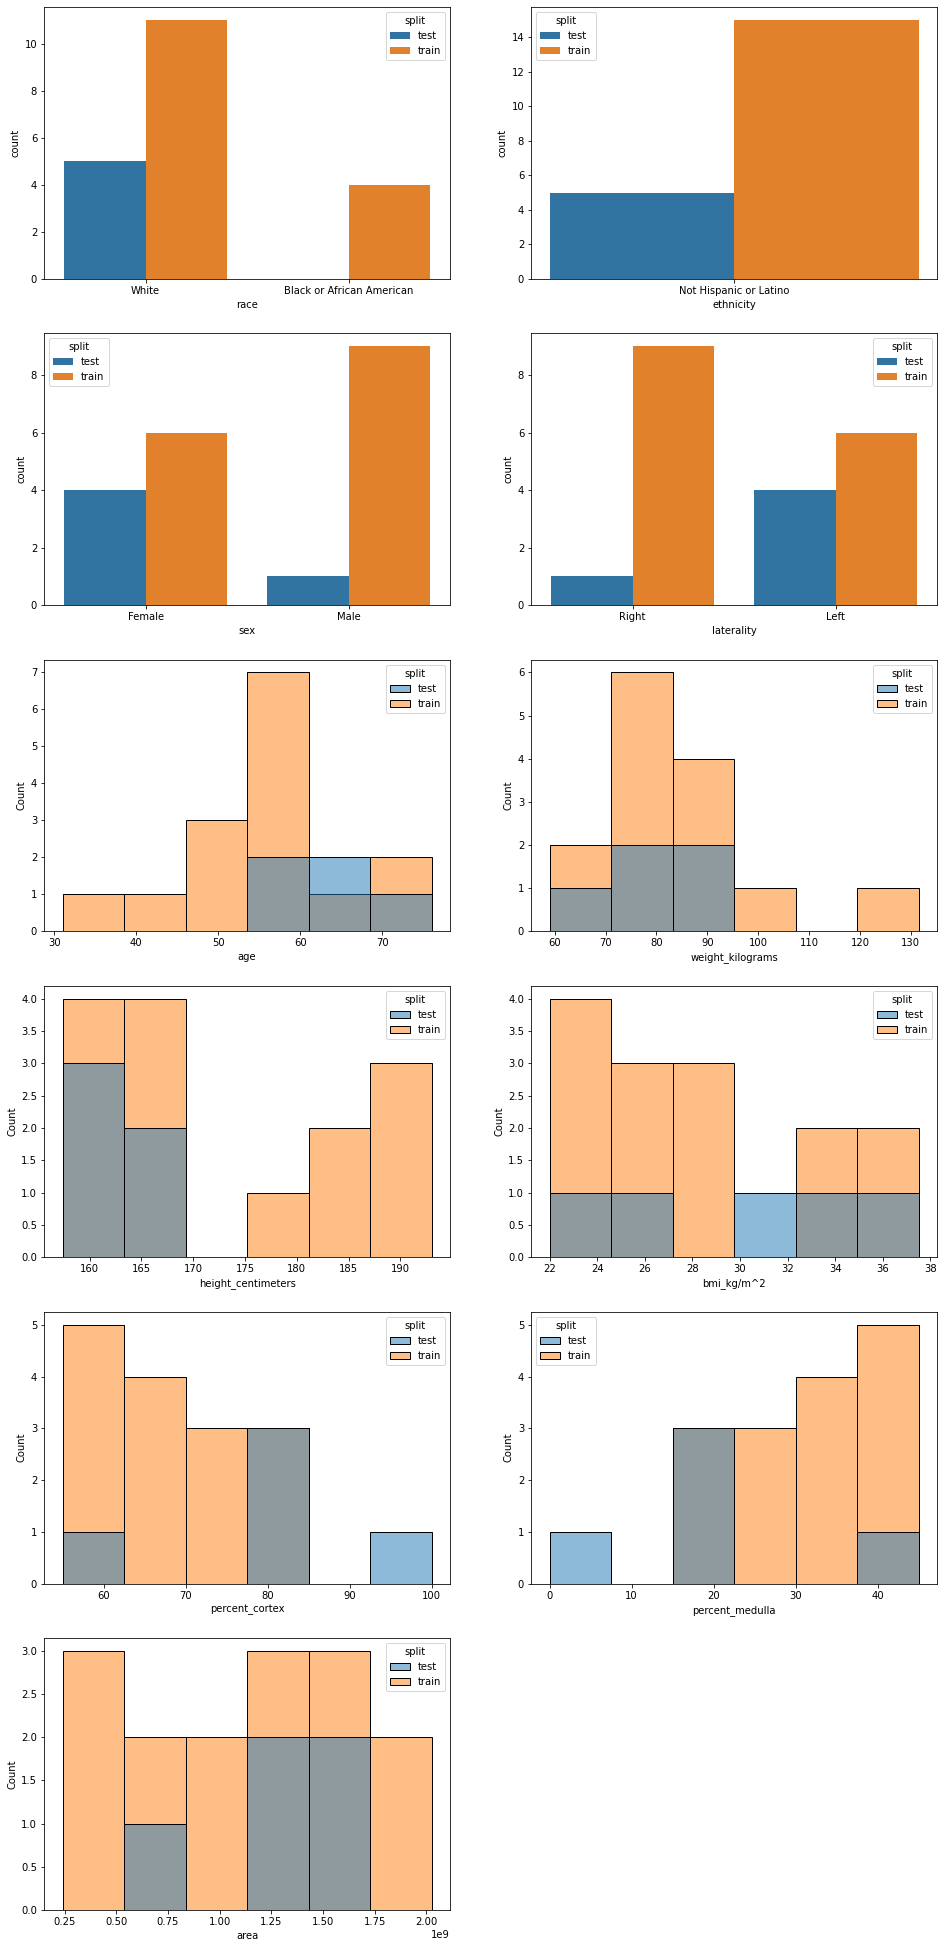

In [38]:
plt.figure(figsize=(16, 35))
plt.subplot(6, 2, 1)
sn.countplot(x="race", hue="split", data=df_info)
plt.subplot(6, 2, 2)
sn.countplot(x="ethnicity", hue="split", data=df_info)
plt.subplot(6, 2, 3)
sn.countplot(x="sex", hue="split", data=df_info)
plt.subplot(6, 2, 4)
sn.countplot(x="laterality", hue="split", data=df_info)
plt.subplot(6, 2, 5)
sn.histplot(x="age", hue="split", data=df_info)
plt.subplot(6, 2, 6)
sn.histplot(x="weight_kilograms", hue="split", data=df_info)
plt.subplot(6, 2, 7)
sn.histplot(x="height_centimeters", hue="split", data=df_info)
plt.subplot(6, 2, 8)
sn.histplot(x="bmi_kg/m^2", hue="split", data=df_info)
plt.subplot(6, 2, 9)
sn.histplot(x="percent_cortex", hue="split", data=df_info)
plt.subplot(6, 2, 10)
sn.histplot(x="percent_medulla", hue="split", data=df_info)
plt.subplot(6, 2, 11)
sn.histplot(x="area", hue="split", data=df_info);

# WORK IN PROGRESS...